# Проект: классификация

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from  sklearn.ensemble import IsolationForest
#import warnings
#warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [38]:
df_full = pd.read_csv('data/bank_fin.zip', sep = ';', compression='zip')
df_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [39]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [40]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df_full.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

> - Пропуски обнаружены в признаке balance.

### Задание 2

In [41]:
df = df_full.copy()

In [42]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

> -  В признаке job в качестве значения использовалось 'unknown', что по факту означет отсутсвие данных.

In [43]:
df['education'].unique()

array(['secondary', 'tertiary', 'primary', 'unknown'], dtype=object)

> -  В признаке education также использвали 'unknown' для заполнения пропусков.

### Задание 3

##### *Для преобразования значений balance во float удаляем знак доллара, пробелы и запятые*

In [44]:
df['balance'] = df['balance'].str.replace("[$ ,]", "", regex=True).astype(float) / 100
df.balance.head()

0    2343.0
1      45.0
2    1270.0
3    2476.0
4     184.0
Name: balance, dtype: float64

### Задание 4

In [45]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
display(f"Среднее значение balance до обработки: {df.balance.mean():.3f}")

df['balance'] = df['balance'].fillna(df.balance.median())
display(f"Среднее значение balance после заполнения пропусков: {df.balance.mean():.3f}")

'Среднее значение balance до обработки: 1529.129'

'Среднее значение balance после заполнения пропусков: 1526.936'

### Задание 5

#### *Заменяем значения 'unknown' в признаках job и education на модальные значения.*

In [46]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].mask(df.job == 'unknown', df.job.mode()[0])
df['education'] = df['education'].mask(df.education == 'unknown', df.education.mode()[0])
display(df.job.unique(), df.education.unique())

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'self-employed', 'student'], dtype=object)

array(['secondary', 'tertiary', 'primary'], dtype=object)

#### *После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.*

In [47]:
mode_je_balance = df[(df.job == df.job.mode()[0]) & (df.education == df.education.mode()[0])].balance.mean()
display(f'Средний баланс для клиентов с модальным значение работы и образования {mode_je_balance:.3f} ')

'Средний баланс для клиентов с модальным значение работы и образования 1598.883 '

### Задание 6

#### *Изучите признак, отображающий баланс клиентов, на предмет выбросов.*

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов. Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха () , а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. (). Найдите эти границы, и отфильтруйте значения так, чтобы выбросов в данных не осталось.



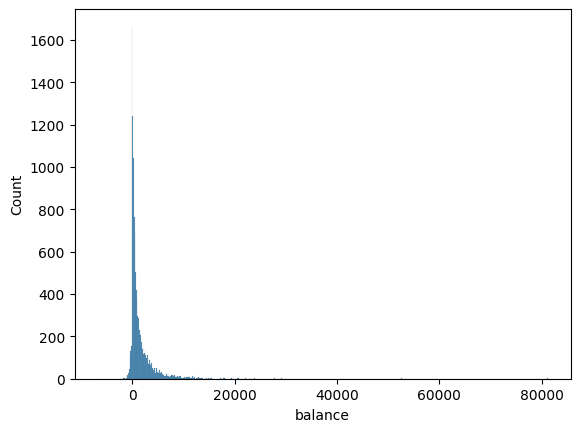

In [48]:
sns.histplot(df.balance);

> - Гистограмма распределения значений признака balance не слишком похожа на нормальное.
> - Но так как по условиям задания следует применить метод Тьюки, расчитываем квартили, отодвигаем границы на 1.5 межквартильного размаха.

In [49]:
balance_percentile_25, balance_percentile_75 = np.percentile(df.balance, [25, 75])
balance_lower_limit = balance_percentile_25 - (balance_percentile_75 - balance_percentile_25) * 1.5
balance_upper_limit = balance_percentile_75 + (balance_percentile_75 - balance_percentile_25) * 1.5
display(f"Нижняя граница выбросов признака balance: {balance_lower_limit:.0f}")
display(f"Верхняя граница выбросов признака balance: {balance_upper_limit:.0f}")

'Нижняя граница выбросов признака balance: -2241'

'Верхняя граница выбросов признака balance: 4063'

In [50]:
# удаляем значение выходящие за пределы нижней или верхней границы, расчитаных по методу межквартильного размаха
df = df.drop(df[(df.balance < balance_lower_limit) | (df.balance > balance_upper_limit)].index)
df.shape

(10105, 17)

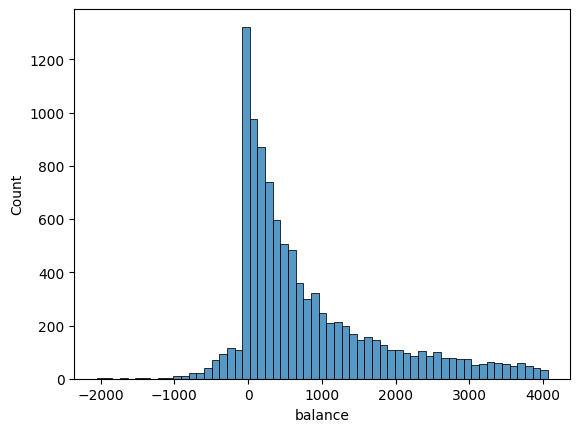

In [51]:
# посмотрим на распределение после удаления выборосов
sns.histplot(df.balance);

> - Распределение не близко к нормальному, больше напоминают логнорамальное распределение.

## Часть 2:  Разведывательный анализ

### Задание 1

In [52]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# выдялем целевой признак, оцениваем его сбалансирвоанность по классам
y = df['deposit']
y.value_counts(True)

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

> - целевая переменная бинарная, классы достаточно сбаласированы, стратификация не требуется

In [53]:
# закодируем целевую переменную в числовой форме, 1 - результат достигнут, 0 - нет
df['deposit'] = df['deposit'].map({'yes':1, 'no':0})

### Задания 2 и 3

In [54]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous,deposit
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230,0.463236
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795,0.498671
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000,1.000000


### Задания 4 и 5

In [55]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#постройте визуализации, иллюстрирующие результаты
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570


### Задание 6

In [56]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby(by='poutcome')['deposit'].mean()

poutcome
failure    0.493237
other      0.550936
success    0.911111
unknown    0.397358
Name: deposit, dtype: float64

### Задание 7

In [57]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby(by='month')['deposit'].mean().sort_values()

month
may    0.321360
jan    0.391850
jul    0.410437
nov    0.415385
aug    0.440433
jun    0.451087
feb    0.544429
apr    0.618072
oct    0.814925
sep    0.834532
mar    0.898734
dec    0.903226
Name: deposit, dtype: float64

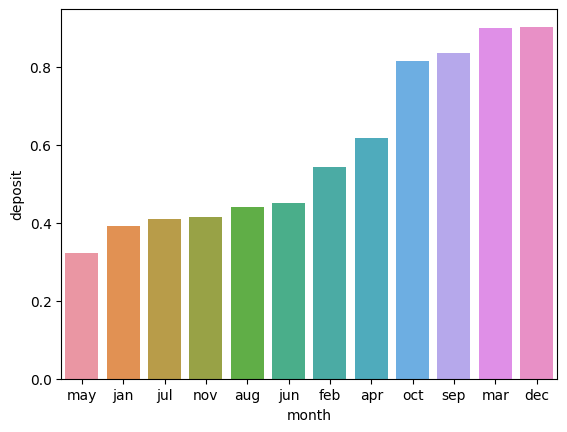

In [58]:
sns.barplot(data=df.groupby(by='month', as_index=False)['deposit'].mean().sort_values(by='deposit'), 
            x='month', y='deposit');

### Задание 8

#### *Нам бы очень хотелось посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.*

Создайте новую переменную, в которой будет находиться индикатор принадлежности к одной из следующих категорий:

'<30';
'30-40';
'40-50';
'50-60';
'60+'.


In [59]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
age_bins = [0, 29, 39, 49, 59, 130]
age_labels = ['<30', '30-39', '40-49', '50-59', '60+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

df['age_group'].value_counts()

30-39    3961
40-49    2382
50-59    1654
<30      1455
60+       653
Name: age_group, dtype: int64

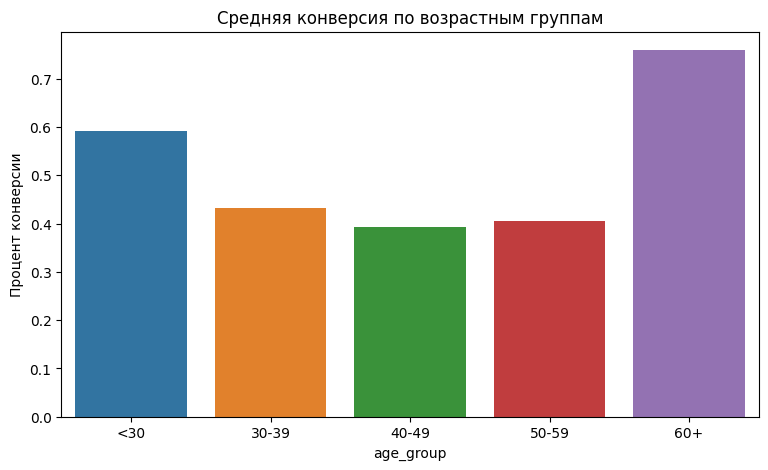

In [60]:
fig, ax = plt.subplots(figsize=(9,5))
ax = sns.barplot(data=df.groupby(by='age_group', as_index=False).deposit.mean(),
                 x='age_group', y='deposit')
ax.set_ylabel('Процент конверсии')
ax.set_title("Средняя конверсия по возрастным группам");

### Задания 9 и 10

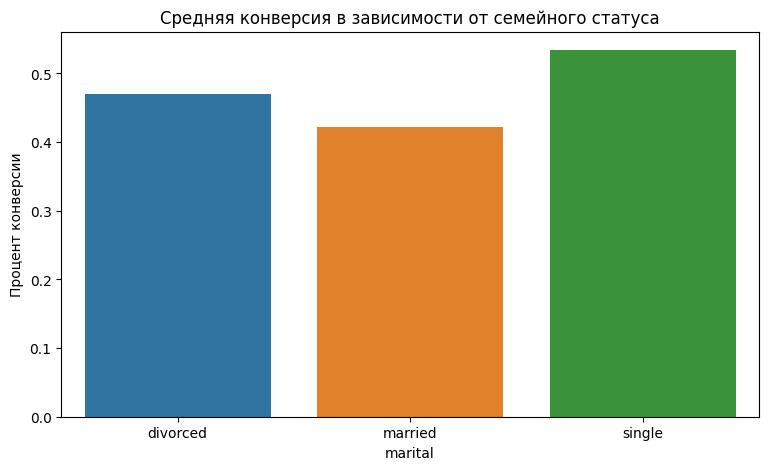

In [61]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig, ax = plt.subplots(figsize=(9,5))
ax = sns.barplot(data=df.groupby(by='marital', as_index=False).deposit.mean(),
                 x='marital', y='deposit')
ax.set_ylabel('Процент конверсии')
ax.set_title("Средняя конверсия в зависимости от семейного статуса");

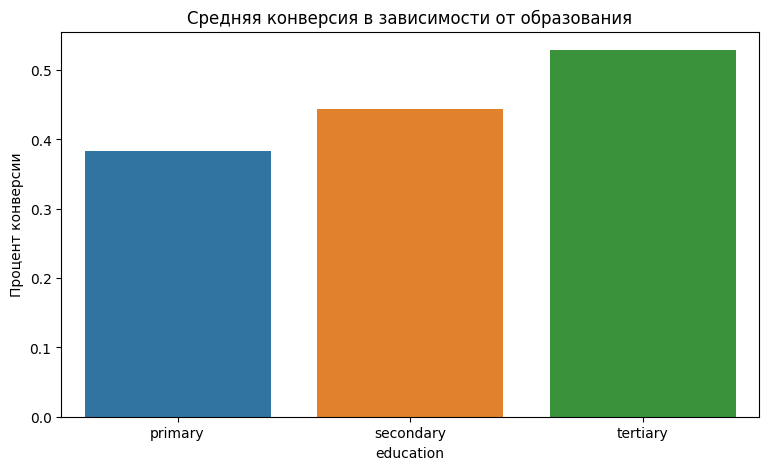

In [62]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig, ax = plt.subplots(figsize=(9,5))
ax = sns.barplot(data=df.groupby(by='education', as_index=False).deposit.mean(),
                 x='education', y='deposit')
ax.set_ylabel('Процент конверсии')
ax.set_title("Средняя конверсия в зависимости от образования");

In [63]:
df.job.value_counts()

management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

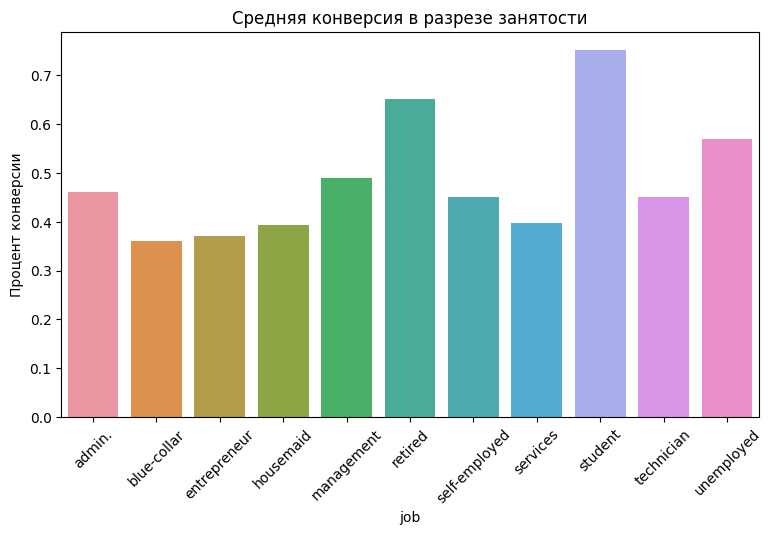

In [64]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig, ax = plt.subplots(figsize=(9,5))
ax = sns.barplot(data=df.groupby(by='job', as_index=False).deposit.mean(),
                 x='job', y='deposit')
ax.set_ylabel('Процент конверсии')
ax.set_title("Средняя конверсия в разрезе занятости")
ax.tick_params(axis='x', rotation=45);

### Задание 11

In [65]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# выделим субтаблицы с положительным и отрицательным результатом маргетинговой компании
df_yes = df[df.deposit == 1]
df_no = df[df.deposit == 0]

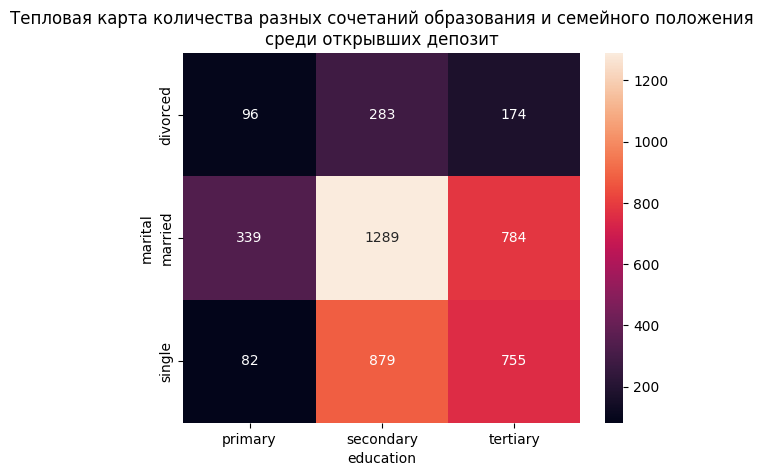

In [66]:
fig, ax = plt.subplots()
ax = sns.heatmap(pd.crosstab(df_yes.marital, df_yes.education), annot=True, fmt='.0f')
ax.set_title("Тепловая карта количества разных сочетаний образования и семейного положения\nсреди открывших депозит");

In [67]:
df_yes.pivot_table(index='marital', columns='education', values='deposit', aggfunc='count')

education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


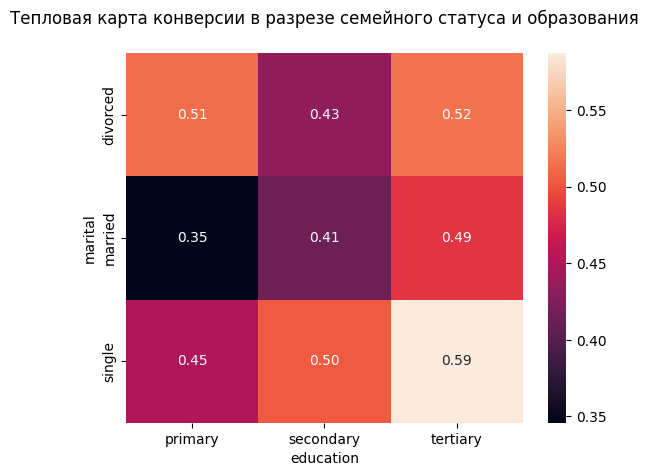

In [68]:
fig, ax = plt.subplots()
ax = sns.heatmap(df.pivot_table(index='marital', columns='education', values='deposit', aggfunc='mean'), annot=True, fmt='.2f')
ax.set_title("Тепловая карта конверсии в разрезе семейного статуса и образования\n");

In [69]:
df['contact'].value_counts(normalize=True)

cellular     0.720732
unknown      0.213855
telephone    0.065413
Name: contact, dtype: float64

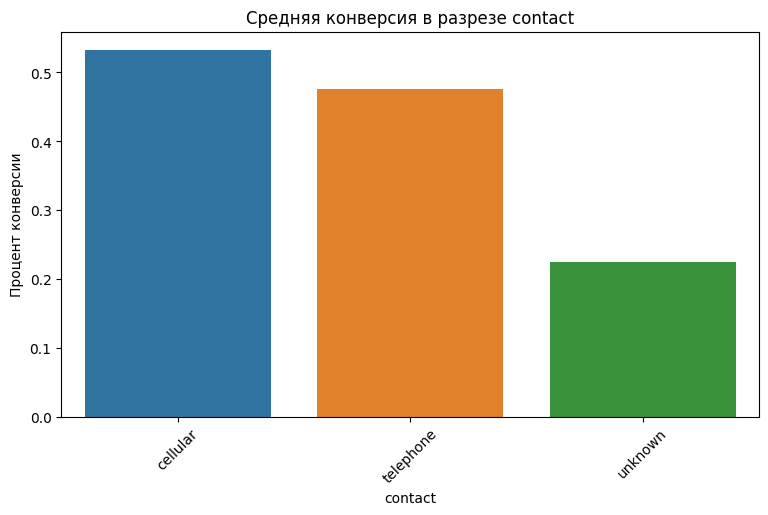

In [70]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig, ax = plt.subplots(figsize=(9,5))
ax = sns.barplot(data=df.groupby(by='contact', as_index=False).deposit.mean(),
                 x='contact', y='deposit')
ax.set_ylabel('Процент конверсии')
ax.set_title("Средняя конверсия в разрезе contact")
ax.tick_params(axis='x', rotation=45);

## Часть 3: преобразование данных

### Задание 1

In [74]:
# преобразуйте уровни образования c помощью LabelEncoder
l_encoder = LabelEncoder()
df['education'] = l_encoder.fit_transform(df['education'])
l_encoder.classes_


array(['primary', 'secondary', 'tertiary'], dtype=object)

In [75]:
age_gr_encoder = LabelEncoder()
df['age_group'] = age_gr_encoder.fit_transform(df['age_group'])
age_gr_encoder.classes_

array(['30-39', '40-49', '50-59', '60+', '<30'], dtype=object)

### Задания 2 и 3

In [76]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['default'].unique(), df['housing'].unique(), df['loan'].unique()

(array(['no', 'yes'], dtype=object),
 array(['yes', 'no'], dtype=object),
 array(['no', 'yes'], dtype=object))

In [78]:
yes_no_col = ['default', 'housing', 'loan']
for col in yes_no_col:
    df[col] = (df[col].to_numpy() == 'yes').astype(int)  # самый быстрый вариант

In [79]:
round(df[yes_no_col].mean().sum(), 3)

0.635

### Задание 4

In [80]:
# создайте дамми-переменные
col_to_dummy = ['job', 'marital', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=col_to_dummy)
df.shape


(10105, 46)

### Задания 5 и 6

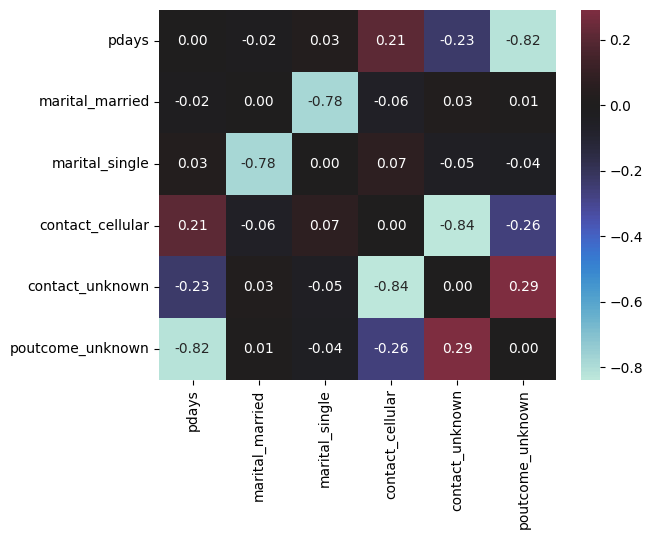

In [81]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr_matrix = df.corr()
np.fill_diagonal(corr_matrix.to_numpy(), 0)  # заменим диагональные значения с 1 на 0
mask = corr_matrix[(corr_matrix > 0.7) | (corr_matrix < -0.7)].any()  # отберем признаки в которых встречается корреляция больше 0.7

sns.heatmap(corr_matrix.loc[mask, mask], center=0, fmt='.2f', annot=True);

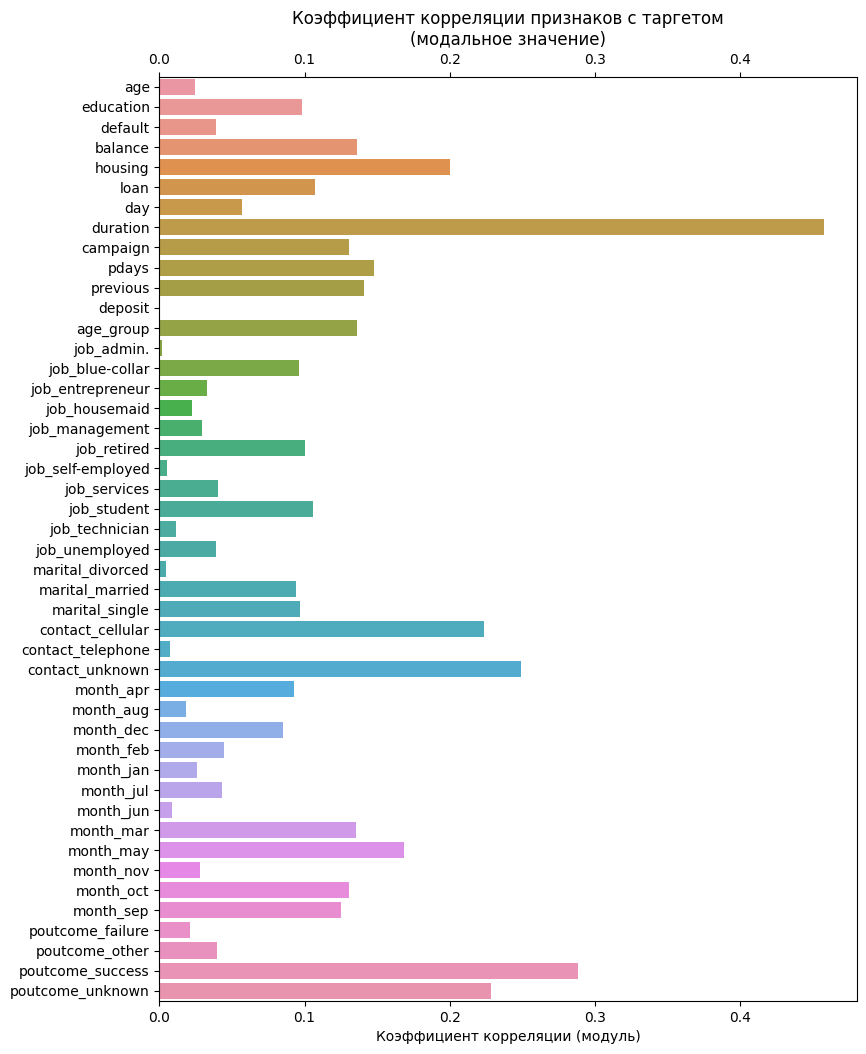

In [82]:
# диаграмма корреляции признаков с целевой переменной
fig, ax = plt.subplots(figsize=(9,12))
ax = sns.barplot(x=np.abs(corr_matrix.deposit), y=corr_matrix.index)
ax.set_title('Коэффициент корреляции признаков с таргетом\n(модальное значение)')
ax.set_xlabel('Коэффициент корреляции (модуль)')
ax.tick_params(axis='x', top=True, labeltop=True, )



### Задания 7 и 8

In [83]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_full_train, X_full_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [84]:
# рассчитайте необходимые показатели
X_full_test.shape

(3335, 45)

In [85]:
round(y_test.mean(), 2)

0.46

### Задание 9

In [86]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_full_train, y_train)

col_selected = selector.get_feature_names_out().tolist()
display(col_selected)

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [87]:
X_train = X_full_train[col_selected].copy()
X_test = X_full_test[col_selected].copy()

### Задание 10

In [88]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [89]:
X_test.iloc[:,0].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

Для начала реализуем самый простой алгоритм, который вам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

Оцените качество модели на тестовой выборке.

In [90]:
# обучите логистическую регрессию и рассчитайте метрики качества
RANDOM_STATE = 42

linear_r = linear_model.LogisticRegression(random_state=RANDOM_STATE, solver='sag', max_iter=1000, penalty='none')
linear_r.fit(X_train, y_train)
y_test_pred = linear_r.predict(X_test)

> - чтобы сошлось с ответом в курсе испльзовал старую версию cikit-learn 1.0.2 и penalty='none'

In [91]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1790
           1       0.82      0.75      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:

criterion = 'entropy';
random_state = 42.
Остальные параметры оставьте по умолчанию.

In [92]:
# обучите решающие деревья, настройте максимальную глубину
decision_tr = tree.DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE)
decision_tr.fit(X_train, y_train)
print(f"Метрика на трейн:\n{metrics.classification_report(y_train, decision_tr.predict(X_train))}")
print(f"Метрика на тест:\n{metrics.classification_report(y_test, decision_tr.predict(X_test))}")

Метрика на трейн:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

Метрика на тест:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.71      0.72      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.74      0.75      3335
weighted avg       0.75      0.75      0.75      3335



In [93]:
decision_tr.get_depth()

36

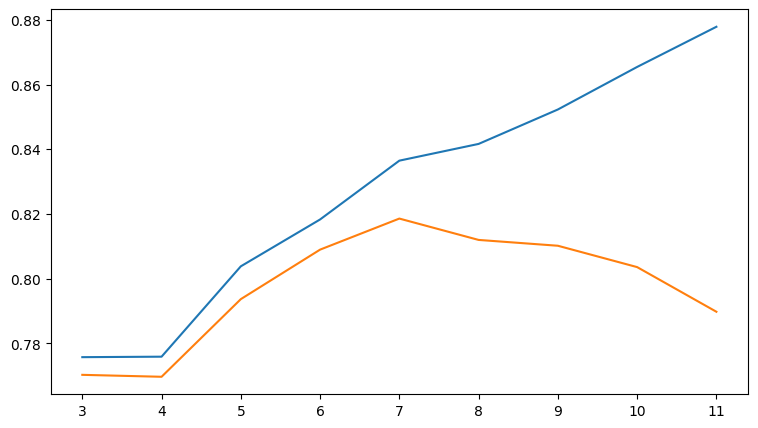

In [94]:
max_depth_range = list(range(3, 12))
accuracy_train_list = []
accuracy_test_list = []

for max_depth in max_depth_range:
    d_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE, max_depth=max_depth)
    d_tree.fit(X_train, y_train)
    accuracy_train_list.append(metrics.accuracy_score(y_train, d_tree.predict(X_train)))
    accuracy_test_list.append(metrics.accuracy_score(y_test, d_tree.predict(X_test)))

fig, ax = plt.subplots(figsize=(9,5))
ax = sns.lineplot(x=max_depth_range, y=accuracy_train_list)
ax = sns.lineplot(x=max_depth_range, y=accuracy_test_list)

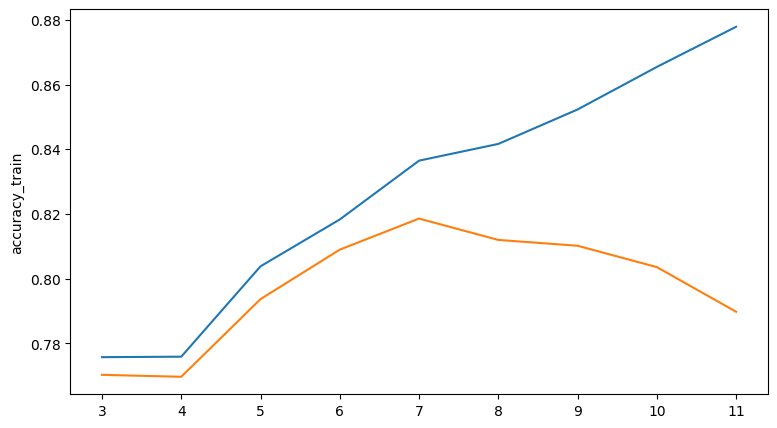

In [95]:
# вариант с датафррейм
max_depth_range = range(3, 12)
max_depth_df = pd.DataFrame(columns=['accuracy_train', 'accuracy_test'])

for max_depth in max_depth_range:
    d_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE, max_depth=max_depth)
    d_tree.fit(X_train, y_train)
    accuracy_train = metrics.accuracy_score(y_train, d_tree.predict(X_train))
    accuracy_test = metrics.accuracy_score(y_test, d_tree.predict(X_test))
    max_depth_df.loc[max_depth] = [accuracy_train, accuracy_test]

fig, ax = plt.subplots(figsize=(9,5))
ax = sns.lineplot(x=max_depth_df.index, y=max_depth_df['accuracy_train'])
ax = sns.lineplot(x=max_depth_df.index, y=max_depth_df['accuracy_test'])

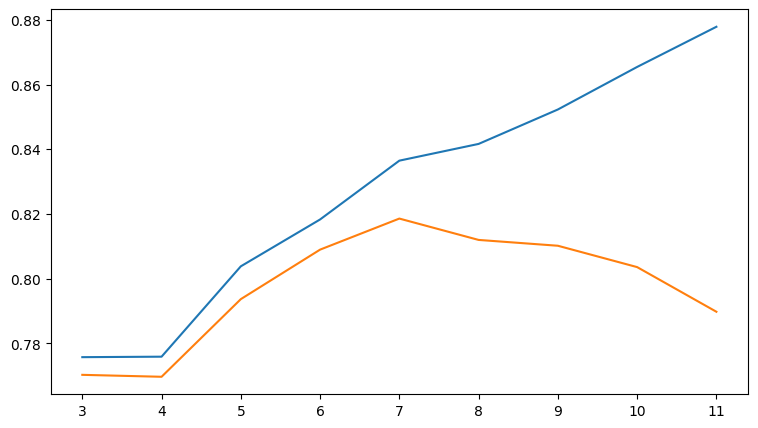

In [96]:
# вариант с использованием функции
def desision_max_depth(max_depth: int):
    d_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE, max_depth=max_depth)
    d_tree.fit(X_train, y_train)
    accuracy_train =  metrics.accuracy_score(y_train, d_tree.predict(X_train))
    accuracy_test = metrics.accuracy_score(y_test, d_tree.predict(X_test))
    return [max_depth, accuracy_train, accuracy_test]

max_depth_range = range(3, 12)
max_depth_arr = np.array([desision_max_depth(n) for n in max_depth_range])

fig, ax = plt.subplots(figsize=(9,5))
ax = sns.lineplot(x=max_depth_arr[:,0], y=max_depth_arr[:, 1])
ax = sns.lineplot(x=max_depth_arr[:,0], y=max_depth_arr[:, 2])

### Задание 5

In [97]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3, 5, 6]
              }
            
grid_search_d_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
grid_search_d_tree.fit(X_train, y_train) 
y_train_pred = grid_search_d_tree.predict(X_train)
y_test_pred = grid_search_d_tree.predict(X_test)


print(f'accuracy на тестовом наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на трейн: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на тест: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f"Наилучшие значения гиперпараметров: {grid_search_d_tree.best_params_}")


accuracy на тестовом наборе: 0.81
f1_score на трейн: 0.81
f1_score на тест: 0.79
Наилучшие значения гиперпараметров: {'max_depth': 6, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

Обучите случайный лес со следующими параметрами:

n_estimators = 100;
criterion = 'gini';
min_samples_leaf = 5;
max_depth = 10;
random_state = 42.

In [98]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(random_state=RANDOM_STATE,
                                     n_estimators = 100,
                                     criterion = 'gini',
                                     min_samples_leaf = 5,
                                     max_depth = 10,
                                     )

rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print(f'Метрика на тест:\n{metrics.classification_report(y_test, y_test_pred)}')

Метрика на тест:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

Дата-сайентист не должен останавливаться на одной модели — он должен пробовать все доступные варианты. Поэтому теперь предлагаем вам сравнить полученные результаты с моделью градиентного бустинга. Используйте градиентный бустинг для решения задачи классификации, задав для него следующие параметры:

learning_rate = 0.05;
n_estimators = 300;
min_samples_leaf = 5;
max_depth = 5;
random_state = 42.

In [99]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    learning_rate=0.05, 
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5, 
    random_state=RANDOM_STATE
)

gb.fit(X_train, y_train)
# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test)
# Посмотрим на основные метрики классификации
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [100]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier

estimators = [
    ('d_tree', tree.DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE, max_depth=6)),
    ('rf', ensemble.RandomForestClassifier(random_state=RANDOM_STATE,
                                     n_estimators = 100,
                                     criterion = 'gini',
                                     min_samples_leaf = 5,
                                     max_depth = 10,
                                     )),
    ('gb', GradientBoostingClassifier(learning_rate=0.05, 
                                      n_estimators=300,
                                      min_samples_leaf=5,
                                      max_depth=5, 
                                      random_state=RANDOM_STATE))
]

st_regr = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=RANDOM_STATE, solver='sag', max_iter=1000, penalty='none'))

st_regr.fit(X_train, y_train)
y_pred = gb.predict(X_test)

print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 5

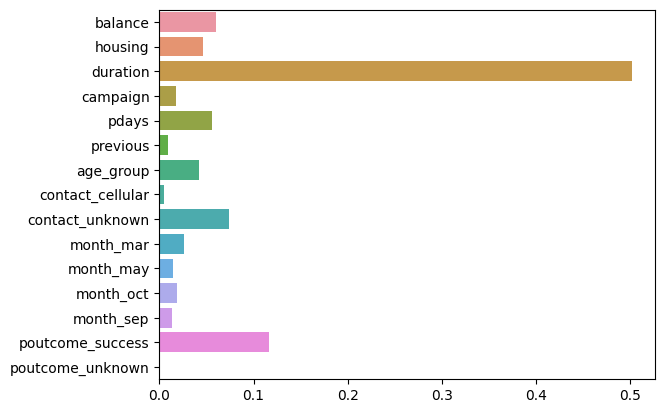

In [101]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
sns.barplot(x=gb.feature_importances_, y=gb.feature_names_in_);

### Задания 6,7,8

Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи GridSearch. Однако вы знаете, что это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna. Примените его для оптимизации гиперпараметров. Для перебора возьмите случайный лес и следующие параметры:

n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
max_depth = trial.suggest_int('max_depth', 10, 30, 1);
min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

In [102]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
from sklearn.model_selection import cross_val_score 

# задаем оценивающую фукцию с сеткой гиперпараметров для алгоритма случайного леса 
def optuna_rf_cv(trial, X_train=X_train, y_train=y_train, cv=5, random_state=RANDOM_STATE):
    # определяем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state,
                                          criterion=criterion
                                          )
    # используем крос-валидацию
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1).mean()

    return score
  

In [103]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
stud_cv = optuna.create_study(study_name="RandomForestClassifier_cv", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
stud_cv.optimize(optuna_rf_cv, n_trials=50)

[I 2023-06-07 14:13:00,989] A new study created in memory with name: RandomForestClassifier_cv
[I 2023-06-07 14:13:01,304] Trial 0 finished with value: 0.8247998831408963 and parameters: {'n_estimators': 120, 'max_depth': 25, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8247998831408963.
[I 2023-06-07 14:13:01,671] Trial 1 finished with value: 0.8235610844753486 and parameters: {'n_estimators': 155, 'max_depth': 17, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8247998831408963.
[I 2023-06-07 14:13:02,125] Trial 2 finished with value: 0.8254007178806433 and parameters: {'n_estimators': 170, 'max_depth': 12, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8254007178806433.
[I 2023-06-07 14:13:02,578] Trial 3 finished with value: 0.8222891824617762 and parameters: {'n_estimators': 182, 'max_depth': 14, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 2 with value: 0.8254007178806433.


CPU times: user 573 ms, sys: 163 ms, total: 736 ms
Wall time: 18.3 s


In [104]:
# выводим результаты на обучающей выборке
print(f"Наилучшие значения гиперпараметров: {stud_cv.best_params}")
print(f"f1_score на обучающем наборе: {stud_cv.best_value:.2f}")

Наилучшие значения гиперпараметров: {'n_estimators': 143, 'max_depth': 27, 'min_samples_leaf': 3, 'criterion': 'entropy'}
f1_score на обучающем наборе: 0.83


In [105]:
# рассчитаем точность для тестовой выборки
model_b = ensemble.RandomForestClassifier(**stud_cv.best_params, random_state=RANDOM_STATE)
model_b.fit(X_train, y_train)

y_train_pred = model_b.predict(X_train)
y_test_pred = model_b.predict(X_test)

print(f'accuracy на тестовом наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на трейн: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на тест: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy на тестовом наборе: 0.82
f1_score на трейн: 0.89
f1_score на тест: 0.82


## Итоговый вывод по проекту:
О чем был этот проект:  
> Банкам хотелось бы уметь выбирать среди своих клиентов именно тех, которые с наибольшей вероятностью воспользуются тем или иным предложением, и связываться именно с ними.`

Звоночек прозвучал, когда предложили оценить какие признаки демонстрируют наибольшую важность в моделях.  
С большим отрывом лидирует duration.  
> duration (продолжительность контакта в секундах).

Основная часть маркетинговой компании велась по телефону.
Логично предположить, если клиент заинтересуется в депозите, нужны дополнительные объяснения. Длительность звонка будет больше.  
Здравствуй,  data leakage.  Очевидно, что duration частично отражает результаты уже проведенной маркетинговой компании.

Как эта модель поможет банку? А никак)  
Думаю, оператор по результатам разговора (директ маркетинг уже случился) предскажет точнее.

Была Бизнес-задача -  рационально использовать ресурсы маркетинга.  
Учебная задача - построить модель для решения.
Мы построили модель, которая будет предсказывать только то, что уже и так известено. Такой вот финал модуля :)


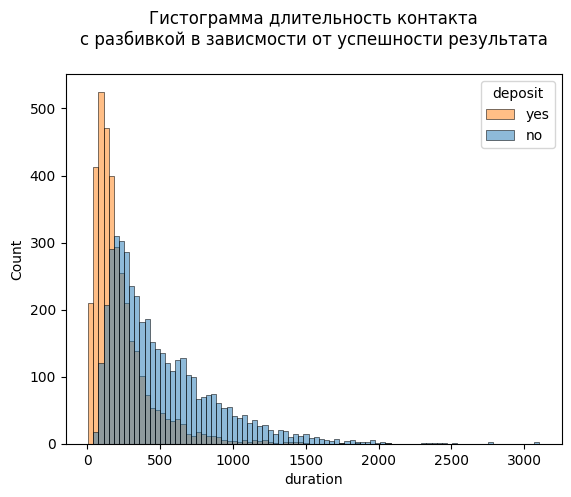

In [109]:
sns.histplot(data=df_full.loc[df_full.contact == 'cellular'], x ='duration', hue='deposit');
plt.legend(labels=['yes', 'no'], title='deposit')
plt.title("Гистограмма длительность контакта\nс разбивкой в зависмости от успешности результата\n");